In [50]:
from math import nan
from re import compile

from matplotlib.font_manager import fontManager, FontProperties
from numpy import arange, array_equal
from pandas import read_csv, DataFrame, concat, Series, isna
from pingouin import ttest
from seaborn import set_style, color_palette, lineplot, FacetGrid, set_theme

In [2]:
measures = DataFrame([
    {"name": "nDCG@5 rel.", "display_name": r"nDCG@5 relevance", "maximize": True, },
    {"name": "nDCG@5 qual.", "display_name": r"nDCG@5 quality", "maximize": True, },
])
measures

,name,display_name,maximize
0,nDCG@5 rel.,nDCG@5 relevance,True
1,nDCG@5 qual.,nDCG@5 quality,True


In [3]:
def target_f1(name: str) -> float:
    parts = name.split(" + ")
    for part in parts:
        if part.startswith("randomize"):
            match = compile(r"randomize\(F1<=(.*)\)").match(part)
            if not match:
                return 1.0
            return float(match.group(1))
    if "ground-truth" in parts:
        return 1.0
    return nan

In [4]:
df: DataFrame = read_csv("../data/metrics-reranking.csv")

# Remove duplicate runs.
df = df.groupby(["name", "qid"], dropna=False, sort=False).aggregate("first").reset_index()

# Pivot measures into column values.
df = concat([
    concat([
        df[["name", "qid", measure]].rename(columns={measure: "value"}),
        DataFrame({"measure": [measure] * len(df)}),
    ], axis=1)
    for measure in measures["name"]
])

# Add run/team/reranker names.
df["run"] = df["name"].apply(lambda name: name.split(" + ", maxsplit=1)[0])
df["team"] = df["run"].apply(lambda run: run.split(" ", maxsplit=1)[0])
df["reranker"] = [
    name.split(" + ", maxsplit=1)[1] if name != run else nan
    for _, (name, run) in df[["name", "run"]].iterrows()
]

# Detect target F1 scores.
df["target_f1"] = df["name"].apply(target_f1)

# Select columns.
df = df[["name", "team", "run", "reranker", "target_f1", "qid", "measure", "value"]]

# Compute aggregated metric values.
df_aggregated = df[["name", "measure", "qid", "value"]].groupby(["name", "measure"], dropna=False,
                                                                sort=False).aggregate("mean").drop(
    columns=["qid"])
df = df.merge(df_aggregated, on=["name", "measure"], suffixes=("", "_aggregated"))

# Add differences to original runs.
df = df.merge(
    df.loc[df["reranker"].isna(), ["qid", "measure", "run", "value", "value_aggregated"]],
    on=["qid", "measure", "run"],
    suffixes=("", "_original"),
).rename(columns={"value_aggregated_original": "value_original_aggregated"})

# Add differences to optimal runs.
df = df.merge(
    df.loc[df["reranker"] == "optimal-relevance@5", ["qid", "measure", "run", "value", "value_aggregated"]],
    on=["qid", "measure", "run"],
    suffixes=("", "_optimal_relevance"),
)
# df = df[df["reranker"] != "optimal-relevance@5"]
df = df.merge(
    df.loc[df["reranker"] == "optimal-quality@5", ["qid", "measure", "run", "value", "value_aggregated"]],
    on=["qid", "measure", "run"],
    suffixes=("", "_optimal_quality"),
)
# df = df[df["reranker"] != "optimal-quality@5"]
df.loc[df["measure"] == "nDCG@5 rel.", "value_optimal"] = df.loc[df["measure"] == "nDCG@5 rel.", "value_optimal_relevance"]
df.loc[df["measure"] == "nDCG@5 rel.", "value_optimal_aggregated"] = df.loc[df["measure"] == "nDCG@5 rel.", "value_aggregated_optimal_relevance"]
del df["value_optimal_relevance"]
del df["value_aggregated_optimal_relevance"]
df.loc[df["measure"] == "nDCG@5 qual.", "value_optimal"] = df.loc[df["measure"] == "nDCG@5 qual.", "value_optimal_quality"]
df.loc[df["measure"] == "nDCG@5 qual.", "value_optimal_aggregated"] = df.loc[df["measure"] == "nDCG@5 qual.", "value_aggregated_optimal_quality"]
del df["value_optimal_quality"]
del df["value_aggregated_optimal_quality"]
df

,name,team,run,reranker,target_f1,qid,measure,value,value_aggregated,value_original,value_original_aggregated,value_optimal,value_optimal_aggregated
0,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,NaN,NaN,100,nDCG@5 rel.,0.170,0.54662,0.170,0.54662,0.339,0.60660
1,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-relevance@5,NaN,100,nDCG@5 rel.,0.339,0.60660,0.170,0.54662,0.339,0.60660
2,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-quality@5,NaN,100,nDCG@5 rel.,0.339,0.56770,0.170,0.54662,0.339,0.60660
3,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,ground-truth + stance-first@5,1.00,100,nDCG@5 rel.,0.339,0.57594,0.170,0.54662,0.339,0.60660
4,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,stance-first@5,NaN,100,nDCG@5 rel.,0.170,0.54642,0.170,0.54662,0.339,0.60660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62395,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.40)@5 + stance-...,0.40,95,nDCG@5 qual.,0.361,0.48602,0.361,0.47622,0.361,0.54428
62396,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.35)@5 + stance-...,0.35,95,nDCG@5 qual.,0.361,0.48246,0.361,0.47622,0.361,0.54428
62397,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.30)@5 + stance-...,0.30,95,nDCG@5 qual.,0.327,0.46664,0.361,0.47622,0.361,0.54428
62398,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.25)@5 + stance-...,0.25,95,nDCG@5 qual.,0.327,0.47548,0.361,0.47622,0.361,0.54428


In [5]:
df[df["value_original"] != df["value_optimal"]]

,name,team,run,reranker,target_f1,qid,measure,value,value_aggregated,value_original,value_original_aggregated,value_optimal,value_optimal_aggregated
0,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,NaN,NaN,100,nDCG@5 rel.,0.170,0.54662,0.170,0.54662,0.339,0.60660
1,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-relevance@5,NaN,100,nDCG@5 rel.,0.339,0.60660,0.170,0.54662,0.339,0.60660
2,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,optimal-quality@5,NaN,100,nDCG@5 rel.,0.339,0.56770,0.170,0.54662,0.339,0.60660
3,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,ground-truth + stance-first@5,1.00,100,nDCG@5 rel.,0.339,0.57594,0.170,0.54662,0.339,0.60660
4,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,stance-first@5,NaN,100,nDCG@5 rel.,0.170,0.54642,0.170,0.54662,0.339,0.60660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62347,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.40)@5 + stance-...,0.40,92,nDCG@5 qual.,0.503,0.48602,0.503,0.47622,0.592,0.54428
62348,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.35)@5 + stance-...,0.35,92,nDCG@5 qual.,0.503,0.48246,0.503,0.47622,0.592,0.54428
62349,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.30)@5 + stance-...,0.30,92,nDCG@5 qual.,0.519,0.46664,0.503,0.47622,0.592,0.54428
62350,Puss-in-Boots BM25-Baseline + ground-truth + r...,Puss-in-Boots,Puss-in-Boots BM25-Baseline,ground-truth + randomize(F1<=0.25)@5 + stance-...,0.25,92,nDCG@5 qual.,0.503,0.47548,0.503,0.47622,0.592,0.54428


In [6]:
short_team_names = {}
team: str
for team in df["team"].sort_values().unique():
    orig_team = team
    for prefix in ["Captain", "Olivier", "Puss-in"]:
        if team.startswith(prefix):
            team = prefix + team.removeprefix(prefix)[:2] + "."
    short_team_names[orig_team] = team.replace("-", " ")
short_team_names

{'Aldo-Nadi': 'Aldo Nadi',
 'Asuna': 'Asuna',
 'Captain-Levi': 'Captain L.',
 'Captain-Tempesta': 'Captain T.',
 'Grimjack': 'Grimjack',
 'Katana': 'Katana',
 'Olivier-Armstrong': 'Olivier A.',
 'Puss-in-Boots': 'Puss in B.'}

In [7]:
short_run_names = {}
for team in df["team"].unique():
    for run, char in zip(df[df["team"] == team]["run"].sort_values().unique(), "ABCDEFGHIJKLMNOPQRSTUVWXYZ"):
        short_run_names[(team, run)] = char
short_run_names

{('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_RF_reranked'): 'A',
 ('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_false_porter'): 'B',
 ('Aldo-Nadi',
  'Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_false_porter_reranked'): 'C',
 ('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_rrf'): 'D',
 ('Aldo-Nadi', 'Aldo-Nadi seupd2122-kueri_rrf_reranked'): 'E',
 ('Asuna', 'Asuna asuna-run-5'): 'A',
 ('Captain-Levi', 'Captain-Levi levirank_baseline_large_duo_t5'): 'A',
 ('Captain-Levi', 'Captain-Levi levirank_dense_initial_retrieval'): 'B',
 ('Captain-Levi', 'Captain-Levi levirank_psuedo_relevance_feedback'): 'C',
 ('Captain-Levi',
  'Captain-Levi levirank_psuedo_relevance_feedback+voting'): 'D',
 ('Captain-Levi', 'Captain-Levi levirank_voting_retrieval'): 'E',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_1'): 'A',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_2'): 'B',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_3'): 'C',
 ('Captain-Tempesta', 'Captain-Tempesta hextech_run_4'): 'D

In [8]:
print(r"\begin{tabular}{@{}lll@{}}")
print(r"    \toprule")
print(r"    \multicolumn{2}{@{}l}{Run} & Run ID \\")
print(r"    \midrule")
for team in df["team"].sort_values().unique():
    for run in df[df["team"] == team]["run"].sort_values().unique():
        print(f"    {team.replace('-', ' ')} & {short_run_names[(team, run)]} & {run.removeprefix(team)[1:]} \\\\")
print(r"    \bottomrule")
print(r"\end{tabular}")

\begin{tabular}{@{}lll@{}}
    \toprule
    \multicolumn{2}{@{}l}{Run} & Run ID \\
    \midrule
    Aldo Nadi & A & seupd2122-kueri_RF_reranked \\
    Aldo Nadi & B & seupd2122-kueri_kueristopv2_BM2_false_porter \\
    Aldo Nadi & C & seupd2122-kueri_kueristopv2_BM2_false_porter_reranked \\
    Aldo Nadi & D & seupd2122-kueri_rrf \\
    Aldo Nadi & E & seupd2122-kueri_rrf_reranked \\
    Asuna & A & asuna-run-5 \\
    Captain Levi & A & levirank_baseline_large_duo_t5 \\
    Captain Levi & B & levirank_dense_initial_retrieval \\
    Captain Levi & C & levirank_psuedo_relevance_feedback \\
    Captain Levi & D & levirank_psuedo_relevance_feedback+voting \\
    Captain Levi & E & levirank_voting_retrieval \\
    Captain Tempesta & A & hextech_run_1 \\
    Captain Tempesta & B & hextech_run_2 \\
    Captain Tempesta & C & hextech_run_3 \\
    Captain Tempesta & D & hextech_run_4 \\
    Captain Tempesta & E & hextech_run_5 \\
    Grimjack & A & grimjack-all-you-need-is-t0 \\
    Grimjack & 

In [9]:
rerankers_table = {
    nan: r"Touch{\'e}",
    "ground-truth + stance-first@5": r"Oracle~{\tiny(\fone=\,1.00)}",
    "ground-truth + randomize(F1<=0.75)@5 + stance-first@5": r"Simul.~{\tiny(\fone<\,0.75)}",
    "gpt3-tsv + stance-first@5": r"GPT-3~{\tiny(\fone=\,0.49)}",
    "google/flan-t5-base@5 + stance-first@5": r"Flan-T5~{\tiny(\fone=\,0.39)}",
    "roberta-csv + stance-first@5": r"\kern-0.25em RoBERTa~{\tiny(\fone=\,0.34)}\kern-0.25em",
    "stance-first@5": r"Orig.~{\tiny(\fone<\,0.36)}",
}
correction_n = len(rerankers_table) + 1

for key in rerankers_table.keys():
    if (not isna(key) and len(df[df["reranker"] == key]) == 0) or (isna(key) and len(df[df["reranker"].isna()]) == 0):
        raise ValueError(f"Re-ranker '{key}' not found.")

In [10]:
df_table = df[
    df["reranker"].isin(rerankers_table.keys()) |
    df["reranker"].isna()
    ]
reranker_index = {
    reranker: i
    for i, reranker in enumerate(rerankers_table.keys())
}


def table_row(df: DataFrame, measure_name: str, run: str, reranker: str) -> Series:
    measure = measures[measures["name"] == measure_name].iloc[0]

    df_reranked = df[df["run"] == run]
    if isna(reranker):
        df_reranked = df_reranked[df_reranked["reranker"].isna()]
    else:
        df_reranked = df_reranked[df_reranked["reranker"] == reranker]

    df_originals = df[df["reranker"].isna()].sort_values("run").sort_values("value_aggregated", ascending=not measure["maximize"])
    run_ranks_original = {run: i + 1 for i, run in enumerate(df_originals["run"].unique())}
    run_rank_original = run_ranks_original[run]
    df_leaderboard = concat([
        df_originals[df_originals["run"] != run],
        df_reranked,
    ])
    df_leaderboard = df_leaderboard.sort_values("run").sort_values("value_aggregated",
                                                                   ascending=not measure["maximize"])
    run_ranks = {run: i + 1 for i, run in enumerate(df_leaderboard["run"].unique())}
    run_rank = run_ranks[run]

    df_original = df_originals[df_originals["run"] == run]

    df_reranked = df_reranked.sort_values("qid")
    df_original = df_original.sort_values("qid")

    if not array_equal(df_original["value"], df_reranked["value"]):
        stats = ttest(df_original["value"], df_reranked["value"], paired=True)
    else:
        stats = DataFrame({
            "p-val": [nan],
            "CI95%": [(nan, nan)],
            "cohen-d": [nan],
        })

    res: Series = df_reranked[[
        "name", "team", "run", "reranker", "measure",
        "value_aggregated", "value_original_aggregated", "value_optimal_aggregated"
    ]].iloc[0]
    res["run_rank"] = run_rank
    res["run_rank_original"] = run_rank_original
    res["reranker_index"] = reranker_index[reranker]
    res["p_value"] = stats["p-val"].iloc[0]
    res["p_value_corrected"] = stats["p-val"].iloc[0] * correction_n
    res["ci95_low"] = stats["CI95%"].iloc[0][0]
    res["ci95_high"] = stats["CI95%"].iloc[0][1]
    res["cohen_d"] = stats["cohen-d"].iloc[0]
    return res


df_table = DataFrame([
    table_row(
        df_table_measure,
        measure,
        run,
        reranker,
    )
    for reranker in rerankers_table.keys()
    for measure, df_table_measure in df_table.groupby("measure", dropna=False, sort=False)
    for run in df_table["run"].unique()
])

df_table.sort_values(["measure", "reranker_index", "run_rank"], ascending=[False, True, True], inplace=True)

df_table

,name,team,run,reranker,measure,value_aggregated,value_original_aggregated,value_optimal_aggregated,run_rank,run_rank_original,reranker_index,p_value,p_value_corrected,ci95_low,ci95_high,cohen_d
10944,Captain-Levi levirank_dense_initial_retrieval,Captain-Levi,Captain-Levi levirank_dense_initial_retrieval,NaN,nDCG@5 rel.,0.75772,0.75772,0.81460,1,1,0,NaN,NaN,NaN,NaN,NaN
9744,Captain-Levi levirank_baseline_large_duo_t5,Captain-Levi,Captain-Levi levirank_baseline_large_duo_t5,NaN,nDCG@5 rel.,0.75512,0.75512,0.81528,2,2,0,NaN,NaN,NaN,NaN,NaN
12144,Captain-Levi levirank_psuedo_relevance_feedbac...,Captain-Levi,Captain-Levi levirank_psuedo_relevance_feedbac...,NaN,nDCG@5 rel.,0.75280,0.75280,0.81268,3,3,0,NaN,NaN,NaN,NaN,NaN
7344,Captain-Levi levirank_voting_retrieval,Captain-Levi,Captain-Levi levirank_voting_retrieval,NaN,nDCG@5 rel.,0.72734,0.72734,0.79032,4,4,0,NaN,NaN,NaN,NaN,NaN
8544,Captain-Levi levirank_psuedo_relevance_feedback,Captain-Levi,Captain-Levi levirank_psuedo_relevance_feedback,NaN,nDCG@5 rel.,0.72146,0.72146,0.78258,5,5,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55348,Grimjack grimjack-fair-argumentative-reranking...,Grimjack,Grimjack grimjack-fair-argumentative-reranking...,stance-first@5,nDCG@5 qual.,0.36526,0.36526,0.42194,22,22,6,NaN,NaN,NaN,NaN,NaN
50548,Grimjack grimjack-baseline + stance-first@5,Grimjack,Grimjack grimjack-baseline,stance-first@5,nDCG@5 qual.,0.36342,0.36342,0.44190,23,23,6,NaN,NaN,NaN,NaN,NaN
51748,Grimjack grimjack-argumentative-axioms + stanc...,Grimjack,Grimjack grimjack-argumentative-axioms,stance-first@5,nDCG@5 qual.,0.36342,0.36342,0.44190,24,24,6,NaN,NaN,NaN,NaN,NaN
54148,Grimjack grimjack-all-you-need-is-t0 + stance-...,Grimjack,Grimjack grimjack-all-you-need-is-t0,stance-first@5,nDCG@5 qual.,0.34436,0.34436,0.41780,25,25,6,NaN,NaN,NaN,NaN,NaN


In [11]:
extra_space_em = 1.3
col_sep_em = 0.3
parts = ["l", r"@{\hspace{" + f"{col_sep_em * 0.9}" + r"em}}", "l"]
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    parts.append(r"@{\hspace{" + f"{extra_space_em}" + r"em}}")
    if isna(reranker):
        parts.append("r")
        parts.append(r"@{\hspace{" + f"{col_sep_em * 0.9}" + r"em}}")
        parts.append("r")
        parts.append(r"@{\hspace{" + f"{extra_space_em}" + r"em}}")
        parts.append("r")
    else:
        parts.append("r")
        parts.append(r"@{\hspace{" + f"{col_sep_em * 0.9}" + r"em}}")
        parts.append("r")
        parts.append("r")
        parts.append(r"@{\hspace{" + f"{col_sep_em * 0.9}" + r"em}}")
        parts.append("r")
print(r"\renewcommand{\tabcolsep}{" + f"{col_sep_em}" + r"em}")
print(r"\begin{tabular}{@{}" + "".join(parts) + r"@{}}")
print(r"    \toprule")

parts = [r"\multicolumn{2}{@{}l}{\textbf{Run}}"]
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    space = "\hspace{" + f"{extra_space_em}" + "em}" if i < len(rerankers_table) - 1 else ""
    if isna(reranker):
        reranker = rerankers_table[nan]
        parts.append("\multicolumn{2}{@{}c@{" + space + r"}}{\textbf{" + reranker + r"}}")
        parts.append("\multicolumn{1}{@{}c@{" + space + r"}}{\textbf{Opt.}}")
    else:
        reranker = rerankers_table[reranker]
        parts.append(r"\multicolumn{4}{@{}c@{" + space + r"}}{\textbf{" + reranker + r"}}")
print("    " + " & ".join(parts) + r" \\")

parts = []
col = 3
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    space = "r{" + f"{extra_space_em}" + "em}" if i < len(rerankers_table) - 1 else ""
    if isna(reranker):
        parts.append("\cmidrule(" + space + "){" + str(col) + "-" + str(col + 1) + "}")
        col += 2
        parts.append("\cmidrule(" + space + "){" + str(col) + "-" + str(col) + "}")
        col += 1
    else:
        parts.append("\cmidrule(" + space + "){" + str(col) + "-" + str(col + 3) + "}")
        col += 4
print("    " + "".join(parts))

parts = ["", ""]
for i, (reranker, df_reranker) in enumerate(df_table.groupby("reranker", dropna=False, sort=False)):
    space = "\hspace{" + f"{extra_space_em}" + "em}" if i < len(rerankers_table) - 1 else ""
    if isna(reranker):
        parts.append(r"Val.")
        parts.append(r"\#")
        parts.append(r"Val.")
    else:
        parts.append(r"Val.")
        parts.append(r"{\tiny$\Delta$}")
        parts.append(r"\#")
        parts.append(r"{\tiny$\Delta$}")
print("    " + " & ".join(parts) + r" \\")
print(r"    \midrule")

rank_worse = r"{\tiny$\downarrow$}"
rank_better = r"{\tiny$\uparrow$}"
rank_equal = r"{\tiny$\phantom{\uparrow}$}"
for i, (measure_name, df_measure) in enumerate(df_table.groupby("measure", dropna=False, sort=False)):
    measure = measures[measures["name"] == measure_name].iloc[0]
    measure_display_name = measure["display_name"]
    if measure_display_name == "nDCG@5 relevance":
        measure_display_name = r"nDCG@5 evaluated using relevance labels"
        perfect_column = "optimal_relevance"
    elif measure_display_name == "nDCG@5 quality":
        measure_display_name = r"nDCG@5 evaluated using argument quality labels"
        perfect_column = "optimal_quality"
    df_measure = df_measure.sort_values("run_rank_original")
    if i > 0:
        print(r"    \midrule")
    print(r"    \multicolumn{" + str(len(parts)) + r"}{@{}l@{}}{\textit{" + measure_display_name + r"}} \\")
    print(r"    \midrule")
    for (team, run), df_run in df_measure.groupby(["team", "run"], dropna=False, sort=False):
        df_run = df_run.sort_values("reranker_index")
        short_team = short_team_names[team]
        short_run = short_run_names[(team, run)]
        short_team = short_team.replace("_", r"\_")
        short_run = short_run.replace("_", r"\_")
        parts = [short_team, short_run]
        for reranker, df_reranker in df_run.groupby("reranker", dropna=False, sort=False):
            value_aggregated = df_reranker["value_aggregated"].iloc[0]
            value_original_aggregated = df_reranker["value_original_aggregated"].iloc[0]
            value_optimal_aggregated = df_reranker[f"value_optimal_aggregated"].iloc[0]
            difference_original_aggregated = value_aggregated - value_original_aggregated
            run_rank = df_reranker["run_rank"].iloc[0]
            run_rank_original = df_reranker["run_rank_original"].iloc[0]
            run_rank_difference = run_rank - run_rank_original
            if isna(reranker):
                parts.append(f"{value_aggregated:.2f}")
                parts.append(f"{run_rank_original:.0f}")
                parts.append(f"{value_optimal_aggregated:.2f}")
            else:
                hidden = "Original" in rerankers_table[reranker] and df_reranker["team"].iloc[0] in ("Aldo-Nadi", "Captain-Tempesta")
                val_str = f"{value_aggregated:.2f}"
                if df_reranker["p_value_corrected"].iloc[0] < 0.05:
                    val_str = r"\textbf{" + val_str + r"}"
                if hidden:
                    val_str = r"\hidden{" + val_str + r"}"
                parts.append(val_str)
                diff_str = f"{'+' if difference_original_aggregated.round(2) >= 0 else '-'}{abs(difference_original_aggregated):.2f}"
                if df_reranker["p_value_corrected"].iloc[0] < 0.05:
                    diff_str = r"\textbf{" + diff_str + r"}"
                if hidden:
                    diff_str = r"\hidden{" + diff_str + r"}"
                parts.append(diff_str)
                rank_str = f"{run_rank:.0f}"
                if hidden:
                    rank_str = r"\hidden{" + rank_str + r"}"
                parts.append(rank_str)
                rank_diff_str = f"{rank_worse if run_rank_difference > 0 else rank_better if run_rank_difference < 0 else rank_equal}{abs(run_rank_difference):.0f}"
                if hidden:
                    rank_diff_str = r"\hidden{" + rank_diff_str + r"}"
                parts.append(rank_diff_str                                 )
        print("    " + " & ".join(parts) + r" \\")

print(r"    \bottomrule")
print(r"\end{tabular}")

\renewcommand{\tabcolsep}{0.3em}
\begin{tabular}{@{}l@{\hspace{0.27em}}l@{\hspace{1.3em}}r@{\hspace{0.27em}}r@{\hspace{1.3em}}r@{\hspace{1.3em}}r@{\hspace{0.27em}}rr@{\hspace{0.27em}}r@{\hspace{1.3em}}r@{\hspace{0.27em}}rr@{\hspace{0.27em}}r@{\hspace{1.3em}}r@{\hspace{0.27em}}rr@{\hspace{0.27em}}r@{\hspace{1.3em}}r@{\hspace{0.27em}}rr@{\hspace{0.27em}}r@{\hspace{1.3em}}r@{\hspace{0.27em}}rr@{\hspace{0.27em}}r@{\hspace{1.3em}}r@{\hspace{0.27em}}rr@{\hspace{0.27em}}r@{}}
    \toprule
    \multicolumn{2}{@{}l}{\textbf{Run}} & \multicolumn{2}{@{}c@{\hspace{1.3em}}}{\textbf{Touch{\'e}}} & \multicolumn{1}{@{}c@{\hspace{1.3em}}}{\textbf{Opt.}} & \multicolumn{4}{@{}c@{\hspace{1.3em}}}{\textbf{Oracle~{\tiny(\fone=\,1.00)}}} & \multicolumn{4}{@{}c@{\hspace{1.3em}}}{\textbf{Simul.~{\tiny(\fone<\,0.75)}}} & \multicolumn{4}{@{}c@{\hspace{1.3em}}}{\textbf{GPT-3~{\tiny(\fone=\,0.49)}}} & \multicolumn{4}{@{}c@{\hspace{1.3em}}}{\textbf{Flan-T5~{\tiny(\fone=\,0.39)}}} & \multicolumn{4}{@{}c@{\hspace{1.3

In [60]:
first_bin = 0.25
last_bin = 1.00
bin_step = 0.05
bins = list(arange(
    first_bin - (bin_step / 2),
    last_bin + (bin_step / 2) + 0.0001,
    bin_step,
))
# bins

In [64]:
difference_data = []
df_tmp = df.copy()
df_tmp = df_tmp[~df_tmp["target_f1"].isna()]
df_tmp["difference_original"] = df_tmp["value"] - df_tmp["value_original"]
for (measure_name, team), df_team in df_tmp.groupby(["measure", "team"], sort=False):
    measure = measures[measures["name"] == measure_name].iloc[0]
    run = df_team.sort_values("value_original_aggregated" , ascending=not measure["maximize"])["run"].iloc[0]
    df_team = df_team[df_team["run"] == run]
    for (target_f1, qid, run), df_group in df_team.groupby(["target_f1", "qid", "run"]):
        assert len(df_group) == 1
        difference_data.append({
            "team": team,
            "run": run,
            "target_f1": target_f1,
            "measure": measure["display_name"],
            "qid": qid,
            "value": df_group["value"].iloc[0],
            "difference": df_group["difference_original"].iloc[0],
        })
df_plot = DataFrame(difference_data)
df_plot["team"] = df_plot["team"].map(short_team_names)
df_plot = df_plot[df_plot["target_f1"] >= first_bin]
df_plot

,team,run,target_f1,measure,qid,value,difference
50,Aldo Nadi,Aldo-Nadi seupd2122-kueri_rrf_reranked,0.25,nDCG@5 relevance,2,0.808,0.000
51,Aldo Nadi,Aldo-Nadi seupd2122-kueri_rrf_reranked,0.25,nDCG@5 relevance,3,0.757,-0.070
52,Aldo Nadi,Aldo-Nadi seupd2122-kueri_rrf_reranked,0.25,nDCG@5 relevance,8,1.000,0.000
53,Aldo Nadi,Aldo-Nadi seupd2122-kueri_rrf_reranked,0.25,nDCG@5 relevance,9,0.339,0.000
54,Aldo Nadi,Aldo-Nadi seupd2122-kueri_rrf_reranked,0.25,nDCG@5 relevance,12,0.827,0.007
...,...,...,...,...,...,...,...
13595,Puss in B.,Puss-in-Boots BM25-Baseline,1.00,nDCG@5 quality,91,0.446,0.000
13596,Puss in B.,Puss-in-Boots BM25-Baseline,1.00,nDCG@5 quality,92,0.592,0.089
13597,Puss in B.,Puss-in-Boots BM25-Baseline,1.00,nDCG@5 quality,93,1.000,0.000
13598,Puss in B.,Puss-in-Boots BM25-Baseline,1.00,nDCG@5 quality,95,0.361,0.000


In [79]:
set_theme(
    style="ticks",
    palette="colorblind",
    font_scale=1.0,
    font="sans-serif",
)

/home/heinrich/Repositories/stare/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


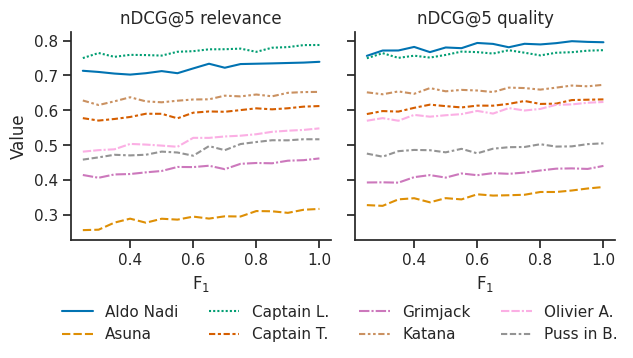

In [81]:
aspect = 1.1
width = 3.5
plot_values = FacetGrid(
    data=df_plot,
    col="measure",
    sharex=True,
    sharey=True,
    height=width / aspect,
    aspect=aspect,
)
plot_values.map_dataframe(
    lineplot,
    x="target_f1",
    y="value",
    hue="team",
    hue_order=df_plot["team"].sort_values().unique(),
    style="team",
    err_style=None,
)
plot_values.set_xlabels(r"F$_1$")
plot_values.set_ylabels(r"Value")
plot_values.add_legend(
    loc="upper left",
    ncols=4,
    bbox_to_anchor=(0.095, 0.06),
)
plot_values.set_titles(col_template="{col_name}")
plot_values.savefig("../data/plot-reranking-f1.pdf", transparent=True)
plot_values.savefig("../data/plot-reranking-f1.png")
plot_values

/home/heinrich/Repositories/stare/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/heinrich/Repositories/stare/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


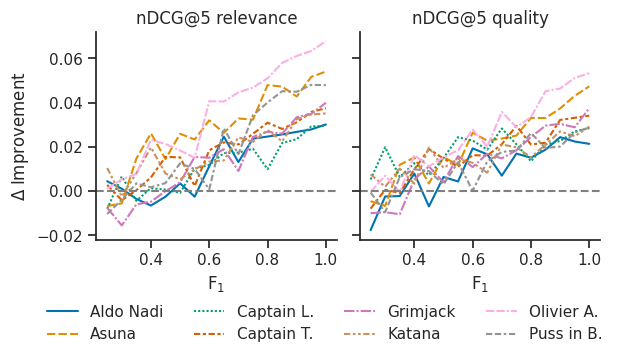

In [87]:
aspect = 1.1
width = 3.5
plot_differences = FacetGrid(
    data=df_plot,
    col="measure",
    sharex=True,
    sharey=True,
    height=width / aspect,
    aspect=aspect,
)
plot_differences.map_dataframe(
    lineplot,
    x="target_f1",
    y="difference",
    hue="team",
    hue_order=df_plot["team"].sort_values().unique(),
    style="team",
    err_style=None,
)
plot_differences.refline(y=0, color="gray")
plot_differences.set_xlabels(r"F$_1$")
plot_differences.set_ylabels(r"$\Delta$ Improvement")
plot_differences.add_legend(
    loc="upper left",
    ncols=4,
    bbox_to_anchor=(0.095, 0.06),
)
plot_differences.set_titles(col_template="{col_name}")
plot_differences.savefig("../data/plot-reranking-f1-difference.pdf", transparent=True)
plot_differences.savefig("../data/plot-reranking-f1-difference.png")
plot_differences

In [88]:
for measure_name, df_measure in df_tmp.groupby("measure", sort=False):
    measure = measures[measures["name"] == measure_name].iloc[0]
    run = df_measure.sort_values("value_original_aggregated" , ascending=not measure["maximize"])["run"].iloc[0]
    df_measure = df_measure[df_measure["run"] == run]
    df_measure = df_measure[df_measure["target_f1"].notna()]
    for target_f1, df_target_f1 in df_measure.groupby("target_f1", sort=True):
        values = df_target_f1["value"]
        values_original = df_target_f1["value_original"]

        if not array_equal(values_original, values):
            stats = ttest(values_original, values, paired=True)
        else:
            stats = DataFrame({
                "p-val": [nan],
                "CI95%": [(nan, nan)],
                "cohen-d": [nan],
            })
        p_val = stats["p-val"].iloc[0] * correction_n
        cohen_d = stats["cohen-d"].iloc[0]
        significant = p_val < 0.05 and values.mean() > values_original.mean()
        if significant:        
            print(f"{measure_name} @ {target_f1:.2f}:", significant, f"{p_val:.2f}", f"{cohen_d:.1f}")
            break
    

nDCG@5 rel. @ 0.90: True 0.03 0.1


In [89]:
for measure_name, df_measure in df_tmp.groupby("measure", sort=False):
    measure = measures[measures["name"] == measure_name].iloc[0]
    df_measure = df_measure[df_measure["target_f1"].notna()]
    for target_f1, df_target_f1 in df_measure.groupby("target_f1", sort=True):
        num_improved = 0
        num_significant = 0
        num_runs = df_target_f1["run"].nunique()
        for run, df_run in df_target_f1.groupby("run", sort=False):
            values = df_run["value"]
            values_original = df_run["value_original"]
            improved = values.mean() > values_original.mean() if measure["maximize"] else values.mean() < values_original.mean()
            if improved:
                num_improved += 1
    
            if not array_equal(values_original, values):
                stats = ttest(values_original, values, paired=True)
            else:
                stats = DataFrame({
                    "p-val": [nan],
                    "CI95%": [(nan, nan)],
                    "cohen-d": [nan],
                })
            p_val = stats["p-val"].iloc[0] * correction_n
            cohen_d = stats["cohen-d"].iloc[0]
            significant = p_val < 0.05 and improved
            if significant:
                num_significant += 1
        print(f"{measure_name} @ {target_f1:.2f}:", 
              # num_improved, num_runs, f"{num_improved/num_runs:.2f}", 
              num_significant, num_runs, f"{num_significant/num_runs:.2f}")
    

nDCG@5 rel. @ 0.20: 0 26 0.00
nDCG@5 rel. @ 0.25: 0 26 0.00
nDCG@5 rel. @ 0.30: 0 26 0.00
nDCG@5 rel. @ 0.35: 0 26 0.00
nDCG@5 rel. @ 0.40: 0 26 0.00
nDCG@5 rel. @ 0.45: 0 26 0.00
nDCG@5 rel. @ 0.50: 2 26 0.08
nDCG@5 rel. @ 0.55: 2 26 0.08
nDCG@5 rel. @ 0.60: 7 26 0.27
nDCG@5 rel. @ 0.65: 10 26 0.38
nDCG@5 rel. @ 0.70: 10 26 0.38
nDCG@5 rel. @ 0.75: 12 26 0.46
nDCG@5 rel. @ 0.80: 16 26 0.62
nDCG@5 rel. @ 0.85: 21 26 0.81
nDCG@5 rel. @ 0.90: 24 26 0.92
nDCG@5 rel. @ 0.95: 26 26 1.00
nDCG@5 rel. @ 1.00: 26 26 1.00
nDCG@5 qual. @ 0.20: 0 26 0.00
nDCG@5 qual. @ 0.25: 0 26 0.00
nDCG@5 qual. @ 0.30: 1 26 0.04
nDCG@5 qual. @ 0.35: 0 26 0.00
nDCG@5 qual. @ 0.40: 0 26 0.00
nDCG@5 qual. @ 0.45: 1 26 0.04
nDCG@5 qual. @ 0.50: 0 26 0.00
nDCG@5 qual. @ 0.55: 1 26 0.04
nDCG@5 qual. @ 0.60: 5 26 0.19
nDCG@5 qual. @ 0.65: 5 26 0.19
nDCG@5 qual. @ 0.70: 5 26 0.19
nDCG@5 qual. @ 0.75: 10 26 0.38
nDCG@5 qual. @ 0.80: 10 26 0.38
nDCG@5 qual. @ 0.85: 14 26 0.54
nDCG@5 qual. @ 0.90: 21 26 0.81
nDCG@5 qual. 